# Baseline: XGBoost

## Importo librerias

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
RANDOM_STATE = 24

## Leo datasets

In [4]:
df_reviews = pd.read_csv("dataset/silkroad_reviews.csv")

## Funciones de encodeo de traget

In [5]:
def encode_target(df, column_name="rating"):
    df[column_name] = df[column_name]
    df[column_name] = df[column_name].apply(lambda x: x if(x==5.0 or x==0.0) else 5.0)
    df[column_name] = df[column_name].replace(5.0, 1.0)
    return df

def decode_target(s):
    res = s.copy()
    res = res.apply(lambda x: 5.0 if(x==1.0) else 5.0)
    return res

In [6]:
df_reviews = encode_target(df_reviews)

## Split del dataset

In [7]:
x = df_reviews.drop(columns=["rating"])
y = df_reviews["rating"]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=RANDOM_STATE)

## Feature engineering

In [9]:
x_train_cf = pd.DataFrame()
x_test_cf = pd.DataFrame()

### Time features

In [10]:
def create_time_features(df, column_name):

    date_col = pd.to_datetime(df[column_name])
    res = pd.DataFrame()
    res["CF|time|year|"+column_name] = date_col.apply(lambda x: x.year)
    res["CF|time|month|"+column_name] = date_col.apply(lambda x: x.month)
    res["CF|time|day|"+column_name] = date_col.apply(lambda x: x.day)
    res["CF|time|dayofweek|"+column_name] = date_col.apply(lambda x: x.dayofweek)
    res["CF|time|quarter|"+column_name] = date_col.apply(lambda x: x.quarter)
    res["CF|time|semester|"+column_name] = date_col.apply(lambda x: x.quarter)

    return res

In [11]:
x_train_cf = create_time_features(x_train, "date_created")
x_test_cf = create_time_features(x_test, "date_created")

### Categorical features

In [12]:
def tfidf_encoding(df, feature_name, prefix, min_df=0.01, df_test= None, isTest = False):
    train = df[feature_name].fillna("")
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english', min_df=min_df)
    tfidf_wm = tfidfvectorizer.fit_transform(train)
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    if(isTest):
        test = df_test[feature_name].fillna("")
        tfidf_wm = tfidfvectorizer.transform(test)
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), columns = tfidf_tokens)
    df_tfidfvect.columns = ["CF|TFIDF|" + prefix + "|" + x for x in df_tfidfvect.columns]
    return df_tfidfvect

#### Column comment

In [13]:
tfidf_encoding(x_train, "comment", "comment", min_df=0.01).head()

x_train_cf = x_train_cf.join(tfidf_encoding(x_train, "comment", "comment", min_df=0.01))
x_test_cf = x_test_cf.join(tfidf_encoding(x_train, "comment", "comment", min_df=0.01, df_test=x_test, isTest=True))

#### Column item_id

In [14]:
x_train["CF|spaced|item_id"] = x_train["item_id"].astype(str).apply(lambda x: (" ").join(x.split("-"))).copy()
x_test["CF|spaced|item_id"] = x_test["item_id"].astype(str).apply(lambda x: (" ").join(x.split("-"))).copy()

<ipython-input-14-e7a044002212>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train["CF|spaced|item_id"] = x_train["item_id"].astype(str).apply(lambda x: (" ").join(x.split("-"))).copy()
<ipython-input-14-e7a044002212>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test["CF|spaced|item_id"] = x_test["item_id"].astype(str).apply(lambda x: (" ").join(x.split("-"))).copy()


In [15]:
x_train_cf = x_train_cf.join(tfidf_encoding(x_train, "item_id", "item_id", min_df=0.01))
x_test_cf = x_test_cf.join(tfidf_encoding(x_train, "item_id", "item_id", min_df=0.01, df_test=x_test, isTest=True))

### Valores nan

In [16]:
x_train_cf = x_train_cf.fillna(x_train_cf.mean())
x_test_cf = x_test_cf.fillna(x_train_cf.mean())

## Aplico algoritmo

In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [18]:
clf = xgb.XGBClassifier(random_state=RANDOM_STATE,
                        objective ='binary:logistic',
                        eval_metric = 'auc',
                       use_label_encoder=False).fit(x_train_cf, y_train)

In [19]:
prediction = clf.predict(x_test_cf)

In [20]:
accuracy_score(prediction, y_test)

0.9455144933993609

In [21]:
pd.Series(prediction).value_counts()

1    78553
dtype: int64

In [22]:
pd.Series(y_test).value_counts()

1.0    74273
0.0     4280
Name: rating, dtype: int64

## Features mas importantes

In [23]:
# Creo un dataframe con la importancia de cada feature

df_features_coef = pd.DataFrame()
df_features_coef["feature"] = x_train_cf.columns
df_features_coef["importance"] = abs(clf.feature_importances_)
df_features_coef.set_index(["feature"], inplace=True)

In [24]:
# Busco los n features mas importantes

n = 30
top_n = df_features_coef["importance"].nlargest(n)

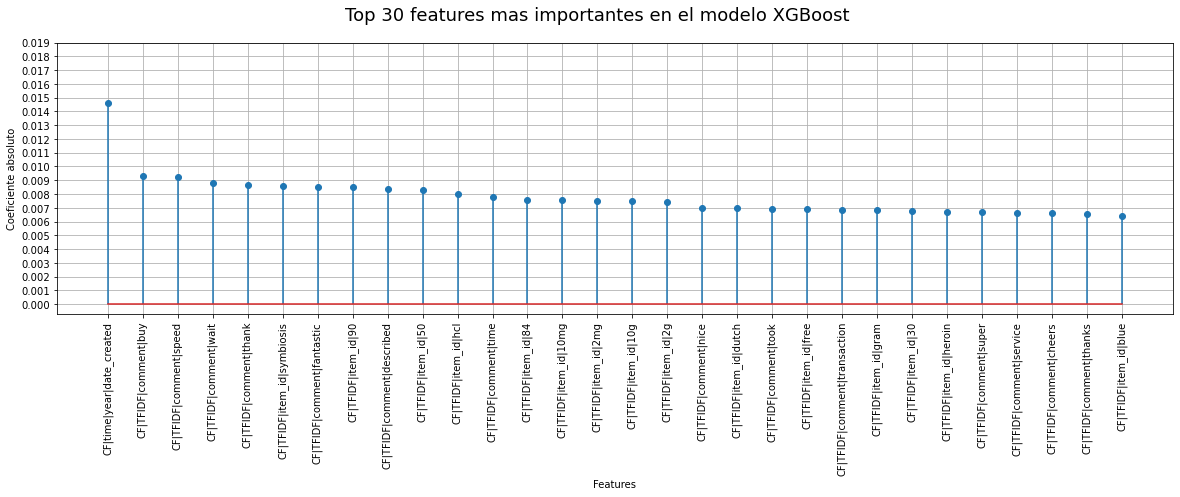

In [25]:
# Grafico los n features mas importantes

fig, axs = plt.subplots(figsize=(20,5))

plt.stem(top_n)
plt.xticks(range(n),top_n.index, rotation=90)
plt.yticks(np.arange(0,0.02,0.001))
plt.grid(True)
plt.xlabel("Features")
plt.ylabel("Coeficiente absoluto")

fig.suptitle("Top 30 features mas importantes en el modelo XGBoost", fontsize=18)

plt.show()